# Forecasting $NO_2$ dengan 30 Hari (14 Lags)

## Agregat Data $NO_2$ Harian

In [1]:
import pandas as pd

# ====== Konfigurasi file ======
input_path = "dataset/no2_gresik_day.csv"       # ganti dengan path CSV Anda
output_path = "dataset/data.csv"    # file keluaran

# ====== Baca data ======
# parse kolom t sebagai tanggal (YYYY-MM-DD)
df = pd.read_csv(input_path, parse_dates=['t'])

# ====== Hapus kolom yang tidak diperlukan ======
cols_drop = [c for c in ['x', 'y', 'crs'] if c in df.columns]
df = df.drop(columns=cols_drop)

# (opsional) pastikan hanya baris dengan nilai NO2 valid yang dipakai
# df = df.dropna(subset=['NO2'])

# ====== Hitung rata-rata NO2 per hari ======
# Jika 't' berformat tanggal penuh dan Anda HANYA ingin bagian harinya:
df['t'] = df['t'].dt.date  # ubah ke tipe date (tanpa jam)

no2_harian = (
    df.groupby('t', as_index=False)['NO2']
      .mean()
      .rename(columns={'NO2': 'NO2_mean'})
)

# ====== Simpan hasil ======
no2_harian.to_csv(output_path, index=False)

print("Contoh 5 baris teratas:")
print(no2_harian.head())
print(f"\nDisimpan ke: {output_path}")


Contoh 5 baris teratas:
            t  NO2_mean
0  2021-09-20  0.000055
1  2021-09-21       NaN
2  2021-09-22  0.000021
3  2021-09-23  0.000032
4  2021-09-24  0.000033

Disimpan ke: dataset/data.csv


### Grafik Data Time Series Harian (Sebelum Interpolasi Linear)

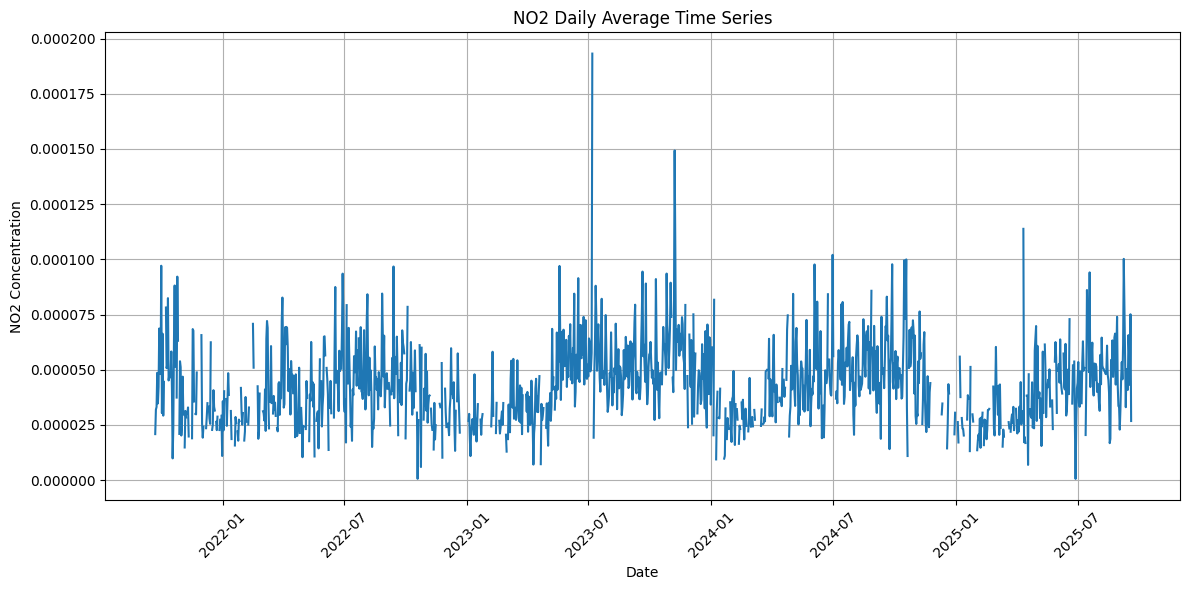

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(no2_harian['t'], no2_harian['NO2_mean'])
plt.title('NO2 Daily Average Time Series')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Terlihat di beberapa tanggal banyak data kosong yang tidak ada nilainya

## Penanganan Missing Value dengan Interpolasi Linear

In [3]:
import pandas as pd


# 1) Pastikan kolom t jadi datetime & urut
tmp = no2_harian.copy()
tmp['t'] = pd.to_datetime(tmp['t'])
tmp = tmp.sort_values('t')

# 2) Buat deret tanggal harian kontinu
full_idx = pd.date_range(tmp['t'].min(), tmp['t'].max(), freq='D')
tmp = tmp.set_index('t').reindex(full_idx)
tmp.index.name = 't'

# 3) Interpolasi linear berbasis waktu
tmp['NO2_mean'] = tmp['NO2_mean'].interpolate(method='time')

# 4) Tutup sisa NaN di tepi (awal/akhir) bila ada
tmp['NO2_mean'] = tmp['NO2_mean'].bfill().ffill()

# 5) Kembalikan ke dataframe final (index → kolom t bertipe date opsional)
no2_harian_filled = tmp.reset_index().rename(columns={'index': 't'})
no2_harian_filled['t'] = no2_harian_filled['t'].dt.date  # opsional: jadikan date murni

# Cek
print(no2_harian_filled.head())


            t  NO2_mean
0  2021-09-20  0.000055
1  2021-09-21  0.000038
2  2021-09-22  0.000021
3  2021-09-23  0.000032
4  2021-09-24  0.000033


# Mengatasi data Outlier

In [4]:
# Import necessary library
from sklearn.preprocessing import RobustScaler

print("Before outlier treatment:")
print(f"Number of rows: {len(no2_harian_filled)}")
print(f"NO2 range: [{no2_harian_filled['NO2_mean'].min():.2f}, {no2_harian_filled['NO2_mean'].max():.2f}]")

# Apply RobustScaler which is robust to outliers
robust_scaler = RobustScaler()
no2_harian_filled['NO2_mean'] = robust_scaler.fit_transform(no2_harian_filled[['NO2_mean']]) * \
                                no2_harian_filled['NO2_mean'].std() + \
                                no2_harian_filled['NO2_mean'].mean()

print("\nAfter outlier treatment:")
print(f"Number of rows: {len(no2_harian_filled)}")
print(f"NO2 range: [{no2_harian_filled['NO2_mean'].min():.2f}, {no2_harian_filled['NO2_mean'].max():.2f}]")


Before outlier treatment:
Number of rows: 1461
NO2 range: [0.00, 0.00]

After outlier treatment:
Number of rows: 1461
NO2 range: [0.00, 0.00]


## Grafik data Time Series (Setelah Interpolasi Linear)

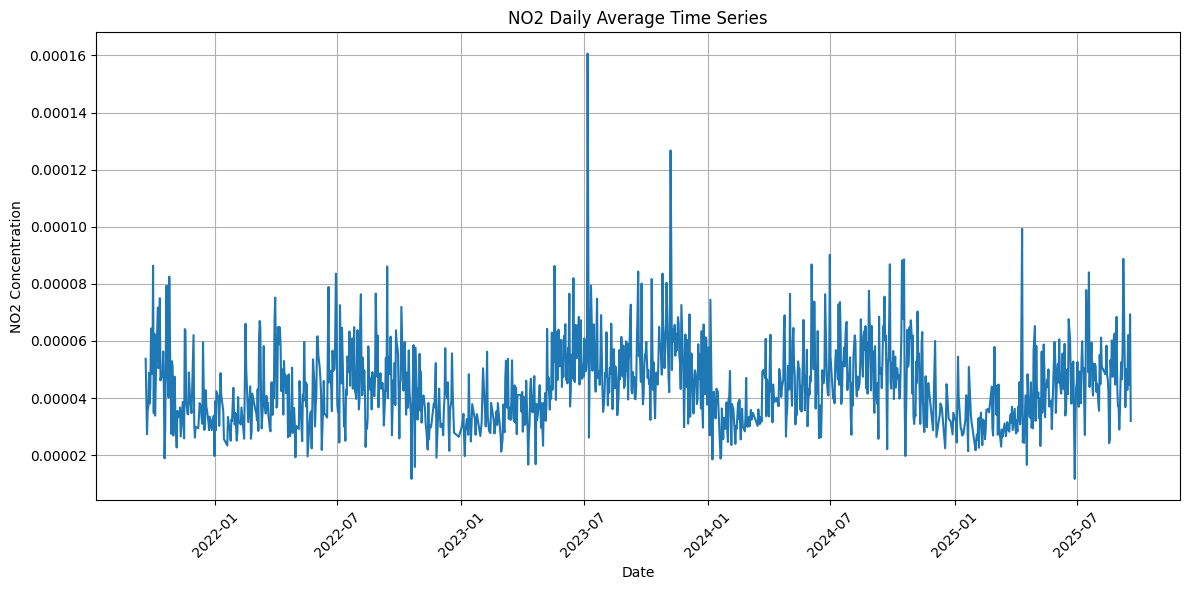

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(no2_harian_filled['t'], no2_harian_filled['NO2_mean'])
plt.title('NO2 Daily Average Time Series')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Mengubah menjadi data Superviesd

In [6]:
def make_supervised_lag(df_daily):
    df = df_daily.copy()

    # Pastikan tipe datetime & urut
    df['t'] = pd.to_datetime(df['t'])
    df = df.sort_values('t')

    # Normalisasi nama kolom nilai → 'NO_2'
    if 'NO2_mean' in df.columns:
        df = df.rename(columns={'NO2_mean': 'NO_2'})
    elif 'NO2' in df.columns:
        df = df.rename(columns={'NO2': 'NO_2'})
    else:
        raise ValueError("Dataframe harus memiliki kolom 'NO2' atau 'NO2_mean'.")

    # Buat kolom lag (h-1 sampai h-30) berbasis waktu harian
    lag_columns = []
    for i in range(1, 30+1):
        col_name = f'h-{i}'
        df[col_name] = df['NO_2'].shift(i)
        lag_columns.append(col_name)
    
    # Buang baris awal yang belum punya lag lengkap
    df = df.dropna(subset=lag_columns).reset_index(drop=True)
    
    # Kembalikan ke date saja untuk kolom t
    df['t'] = df['t'].dt.date

    return df

# Pakai fungsi:
df = make_supervised_lag(no2_harian_filled)
print("Shape dataframe:", df.shape)
print("\nDaftar kolom:")
print(df.columns.tolist())
print("\nContoh 5 baris pertama:")
print(df.head())

Shape dataframe: (1431, 32)

Daftar kolom:
['t', 'NO_2', 'h-1', 'h-2', 'h-3', 'h-4', 'h-5', 'h-6', 'h-7', 'h-8', 'h-9', 'h-10', 'h-11', 'h-12', 'h-13', 'h-14', 'h-15', 'h-16', 'h-17', 'h-18', 'h-19', 'h-20', 'h-21', 'h-22', 'h-23', 'h-24', 'h-25', 'h-26', 'h-27', 'h-28', 'h-29', 'h-30']

Contoh 5 baris pertama:
            t      NO_2       h-1       h-2       h-3       h-4       h-5  \
0  2021-10-20  0.000060  0.000030  0.000019  0.000043  0.000056  0.000049   
1  2021-10-21  0.000079  0.000060  0.000030  0.000019  0.000043  0.000056   
2  2021-10-22  0.000051  0.000079  0.000060  0.000030  0.000019  0.000043   
3  2021-10-23  0.000046  0.000051  0.000079  0.000060  0.000030  0.000019   
4  2021-10-24  0.000040  0.000046  0.000051  0.000079  0.000060  0.000030   

        h-6       h-7       h-8  ...      h-21      h-22      h-23      h-24  \
0  0.000047  0.000048  0.000046  ...  0.000056  0.000064  0.000044  0.000038   
1  0.000049  0.000047  0.000048  ...  0.000048  0.000056  0.0000

Merubah data time series dengan target $NO_2$, menjadi data dengan 3 fitur tambahan.

Data fitur tambahan dihasilkan dari 3 data hari sebelumnya.

Contoh : Untuk data target tanggal 23 September 2021, menggunakan data $NO_2$ saat tanggal 22, 21, dan 20 September, dan seterusnya.

## Seleksi Fitur Auto Correlation

In [7]:
# Ambil semua kolom lag yang ada di df
lag_cols = [c for c in df.columns if c.startswith('h-')]

print("Kolom lag yang tersedia:", lag_cols)

corr_signed = df[lag_cols + ['NO_2']].corr()['NO_2'].drop('NO_2')
# Create correlation table
corr_table = pd.DataFrame({
    'Nama Fitur': lag_cols,
    'Nilai Korelasi': corr_signed.values
}).sort_values('Nilai Korelasi', ascending=False)

# Format table display
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Display the formatted table
print("Tabel Autokorelasi dengan Target NO_2:")
print("=====================================")
print(corr_table.to_string(index=False))

Kolom lag yang tersedia: ['h-1', 'h-2', 'h-3', 'h-4', 'h-5', 'h-6', 'h-7', 'h-8', 'h-9', 'h-10', 'h-11', 'h-12', 'h-13', 'h-14', 'h-15', 'h-16', 'h-17', 'h-18', 'h-19', 'h-20', 'h-21', 'h-22', 'h-23', 'h-24', 'h-25', 'h-26', 'h-27', 'h-28', 'h-29', 'h-30']
Tabel Autokorelasi dengan Target NO_2:
Nama Fitur  Nilai Korelasi
       h-1        0.543573
       h-5        0.351518
       h-6        0.338853
       h-2        0.335974
      h-11        0.334643
      h-10        0.329171
      h-21        0.323407
       h-4        0.320462
       h-8        0.306747
       h-9        0.306632
      h-22        0.305773
       h-7        0.304302
      h-16        0.302203
      h-28        0.301058
      h-27        0.299811
      h-14        0.299437
       h-3        0.297925
      h-13        0.295412
      h-18        0.290909
      h-12        0.288649
      h-20        0.279153
      h-19        0.270082
      h-15        0.269683
      h-17        0.267475
      h-23        0.246546
  

In [8]:
# Filter features with correlation > 0.3
selected_feats = corr_table[corr_table['Nilai Korelasi'] > 0.3]['Nama Fitur'].tolist()

print("Features with correlation > 0.3:")
print("\nSelected features:", selected_feats)
print("\nNumber of selected features:", len(selected_feats))

# Pastikan hanya memilih kolom yang ada di df
selected_feats_valid = [f for f in selected_feats if f in df.columns]
print("\nSelected features (valid):", selected_feats_valid)
print("\nNumber of valid selected features:", len(selected_feats_valid))
selected_feats_valid = selected_feats_valid[::-1]
df = df[['t'] + selected_feats_valid + ['NO_2']]

df.head()

Features with correlation > 0.3:

Selected features: ['h-1', 'h-5', 'h-6', 'h-2', 'h-11', 'h-10', 'h-21', 'h-4', 'h-8', 'h-9', 'h-22', 'h-7', 'h-16', 'h-28']

Number of selected features: 14

Selected features (valid): ['h-1', 'h-5', 'h-6', 'h-2', 'h-11', 'h-10', 'h-21', 'h-4', 'h-8', 'h-9', 'h-22', 'h-7', 'h-16', 'h-28']

Number of valid selected features: 14


,t,h-28,h-16,h-7,h-22,h-9,h-8,h-4,h-21,h-10,h-11,h-2,h-6,h-5,h-1,NO_2
0,2021-10-20,0.000027,0.000034,0.000048,0.000064,0.000075,0.000046,0.000056,0.000056,0.000052,0.000050,0.000019,0.000047,0.000049,0.000030,0.000060
1,2021-10-21,0.000036,0.000046,0.000047,0.000056,0.000046,0.000048,0.000043,0.000048,0.000075,0.000052,0.000030,0.000049,0.000056,0.000060,0.000079
2,2021-10-22,0.000037,0.000054,0.000049,0.000048,0.000048,0.000047,0.000019,0.000086,0.000046,0.000075,0.000060,0.000056,0.000043,0.000079,0.000051
3,2021-10-23,0.000049,0.000063,0.000056,0.000086,0.000047,0.000049,0.000030,0.000035,0.000048,0.000046,0.000079,0.000043,0.000019,0.000051,0.000046
4,2021-10-24,0.000038,0.000072,0.000043,0.000035,0.000049,0.000056,0.000060,0.000063,0.000047,0.000048,0.000051,0.000019,0.000030,0.000046,0.000040


## Scalling Min-Max Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Menyimpan data ori 14 Lags ke file 
df_ori14lags = df.copy()
df.to_csv('dataset/dataOri14Lags', index=False)

cols_to_scale = [c for c in df.columns if c != 't']

df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

df_scaled.head()

df = df_scaled.copy()

# Menyimpan data ori 14 Lags ke file 
df.to_csv('dataset/data14LagsNorm.csv',index=False)

Kode tersebut membuat **MinMaxScaler(0–1)** lalu menerapkannya ke **semua kolom kecuali `t`**, sehingga setiap kolom numerik dipetakan ke rentang ([0,1]). Hasilnya disalin ke `df_scaled`, kemudian disalin kembali ke `df` dan **disimpan** sebagai CSV di `dataset/data14LagsNorm.csv` tanpa indeks. Singkatnya: normalisasi fitur → pratinjau (`head()`) → simpan dataset yang sudah diskalakan.

In [10]:
df_ori14lags.head()

,t,h-28,h-16,h-7,h-22,h-9,h-8,h-4,h-21,h-10,h-11,h-2,h-6,h-5,h-1,NO_2
0,2021-10-20,0.000027,0.000034,0.000048,0.000064,0.000075,0.000046,0.000056,0.000056,0.000052,0.000050,0.000019,0.000047,0.000049,0.000030,0.000060
1,2021-10-21,0.000036,0.000046,0.000047,0.000056,0.000046,0.000048,0.000043,0.000048,0.000075,0.000052,0.000030,0.000049,0.000056,0.000060,0.000079
2,2021-10-22,0.000037,0.000054,0.000049,0.000048,0.000048,0.000047,0.000019,0.000086,0.000046,0.000075,0.000060,0.000056,0.000043,0.000079,0.000051
3,2021-10-23,0.000049,0.000063,0.000056,0.000086,0.000047,0.000049,0.000030,0.000035,0.000048,0.000046,0.000079,0.000043,0.000019,0.000051,0.000046
4,2021-10-24,0.000038,0.000072,0.000043,0.000035,0.000049,0.000056,0.000060,0.000063,0.000047,0.000048,0.000051,0.000019,0.000030,0.000046,0.000040


# Modeling 14 Lags

## Split dataset

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = df[selected_feats_valid].copy()
y = df['NO_2'].copy()
tanggal = pd.to_datetime(df['t'])

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, tanggal, test_size=0.2, shuffle=False)


## Modeling Data Training

In [12]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# --- scorer: MAPE dengan epsilon agar stabil saat y≈0 ---
def mape_eps(y_true, y_pred, eps=1e-3):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

mape_scorer = make_scorer(mape_eps, greater_is_better=False)  # minimization

# --- CV khas time series (tanpa shuffle) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- ruang hyperparameter ---
param_grid = {
    "n_neighbors": [2, 3, 5, 7, 9, 11, 15, 21, 31],
    "weights": ["distance", "uniform"],
    "p": [1, 2],                       # 1=Manhattan, 2=Euclidean (masih metric='minkowski')
    "algorithm": ["auto", "ball_tree", "kd_tree"],
    "leaf_size": [15, 30, 45]
}

# --- grid search ---
knn_base = KNeighborsRegressor(metric="minkowski")
gsearch = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring=mape_scorer,   # pakai MAPE_eps
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

gsearch.fit(X_train, y_train)

# --- gunakan model terbaik untuk langkah berikutnya ---
knn = gsearch.best_estimator_
print("Best params:", gsearch.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best params: {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}


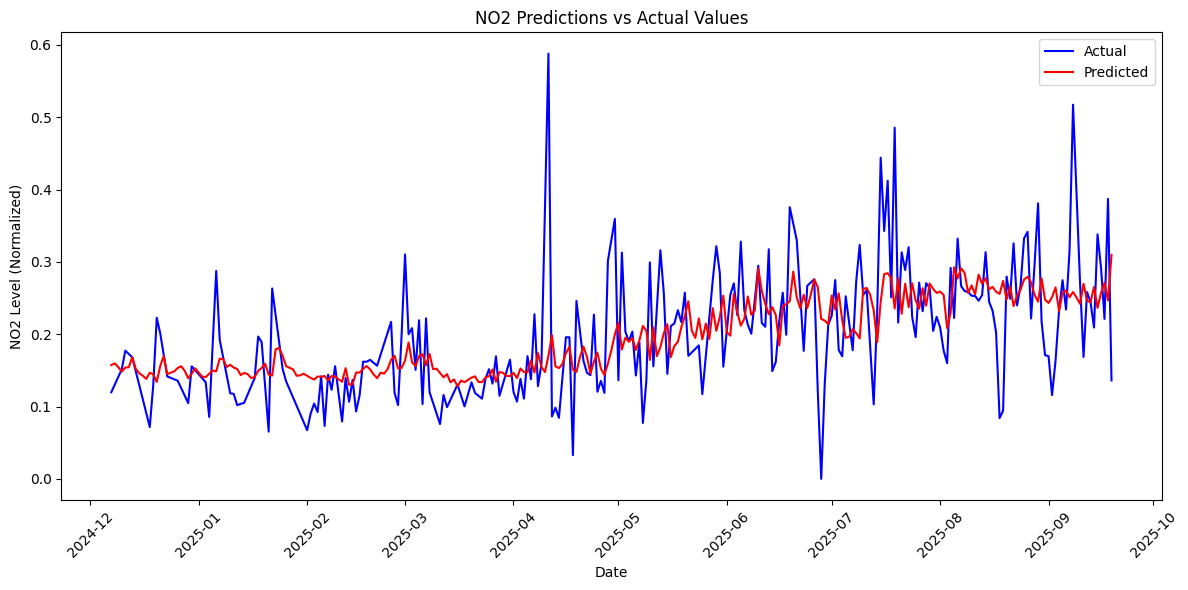

Modified MAPE: 29.10%
RMSE: 0.070682
R2 Score: 0.307824

Prediksi NO_2 untuk hari esok: 2.6603851932868174
NO2 Level Category: Baik


In [13]:
def convertToMikroGramperM3(value):
    return (value * 46.006 * 10**3)

# Categorize NO2 level
def categorize_no2(value):
    if value < 50:
        return "Baik"
    elif value < 100:
        return "Sedang" 
    elif value < 200 :
        return "Tidak Sehat"
    elif value < 300:
        return "Sangat Tidak Sehat"
    else:
        return "Berbahaya"
    
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# Calculate predictions on test set
y_pred = knn.predict(X_test)

# Calculate MAPE
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(t_test, y_test, label='Actual', color='blue')
plt.plot(t_test, y_pred, label='Predicted', color='red')
plt.title('NO2 Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('NO2 Level (Normalized)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate modified MAPE avoiding division by zero
def modified_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = modified_mape(y_test, y_pred)
print(f"Modified MAPE: {mape:.2f}%")

# Calculate other metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2 Score: {r2:.6f}")
# Predict next day
last_row = X.iloc[-1:] 
next_day_pred = knn.predict(last_row)

# Denormalize prediction
next_day_denorm = next_day_pred * scaler.data_range_[-1] + scaler.data_min_[-1]
print(f"\nPrediksi NO_2 untuk hari esok: {convertToMikroGramperM3(next_day_denorm[0])}")



category = categorize_no2(convertToMikroGramperM3(next_day_denorm[0]))
print(f"NO2 Level Category: {category}")

